# **Lecture 5: Examples of GLM and GAM**
>
>- GLM: Generalized Linear Models (logical regression is a special GLM)
>- GAM: Generalized Additive Models
>
>

## ***Part I: GLM***
>
>- Generalized linear models of different kinds are used based on the probability distribution of the response variables: 
>- GLM is particularly useful when the response variable is not normally distributed or when the relationship between the predictor variables and the response variable is non-linear.
>

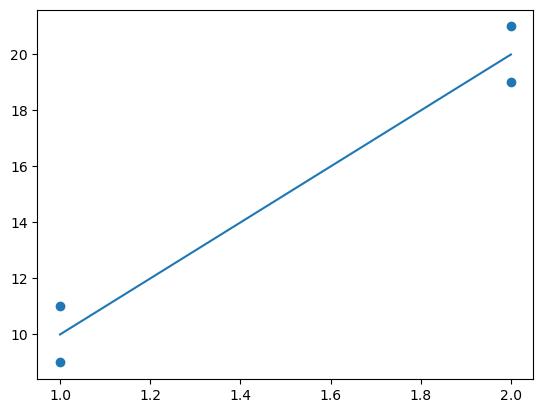

In [25]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
x = [[1], [1], [2], [2]]
y = [9, 11, 19, 21]
m = LinearRegression()
m.fit(x, y)
m.predict([[1]]) # Returns 10
m.predict([[2]]) # Returns 20
m.intercept_, m.coef_
plt.scatter(x,y)
plt.plot(x,m.predict(x))
plt.show()

In [26]:
from sklearn.linear_model import LinearRegression
x = [[7],[8],[9]]
y = [0.50, 0.40, 0.30]
m = LinearRegression()
m.fit(x, y)
m.predict([[1], [20]]) # Returns 110% and -80%

array([ 1.1, -0.8])

If the model give unrealistic extrapolation results, transformations of the model’s inputs or outputs could help to add the constraints, such as put the data into a logarithmic scale and hope for your model to work.
>
>- A link function, that links E(y|x) to the linear equation.
>- The targets follow an exponential distribution. The normal distribution is just one member of this exponential family.
>- Poission Regression and Gamma Regression are two good examples

## 1.1, Poission regression

### ***The French Motor Third-Party Liability Claims dataset***

This is the example from Scikit learn website (https://scikit-learn.org/stable/auto_examples/linear_model/plot_poisson_regression_non_normal_loss.html#sphx-glr-auto-examples-linear-model-plot-poisson-regression-non-normal-loss-py) provided by
> Authors: 
>-       Christian Lorentzen <lorentzen.ch@gmail.com>
>-       Roman Yurchak <rth.yurchak@gmail.com>
>-       Olivier Grisel <olivier.grisel@ensta.org>


In [27]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import fetch_openml


df = fetch_openml(data_id=41214, as_frame=True, parser="pandas").frame
df

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region
0,1.0,1,0.10000,D,5,0,55,50,B12,'Regular',1217,R82
1,3.0,1,0.77000,D,5,0,55,50,B12,'Regular',1217,R82
2,5.0,1,0.75000,B,6,2,52,50,B12,'Diesel',54,R22
3,10.0,1,0.09000,B,7,0,46,50,B12,'Diesel',76,R72
4,11.0,1,0.84000,B,7,0,46,50,B12,'Diesel',76,R72
...,...,...,...,...,...,...,...,...,...,...,...,...
678008,6114326.0,0,0.00274,E,4,0,54,50,B12,'Regular',3317,R93
678009,6114327.0,0,0.00274,E,4,0,41,95,B12,'Regular',9850,R11
678010,6114328.0,0,0.00274,D,6,2,45,50,B12,'Diesel',1323,R82
678011,6114329.0,0,0.00274,B,4,0,60,50,B12,'Regular',95,R26


Average Frequency = 0.10070308464041304
Fraction of exposure with zero claims = 93.9%


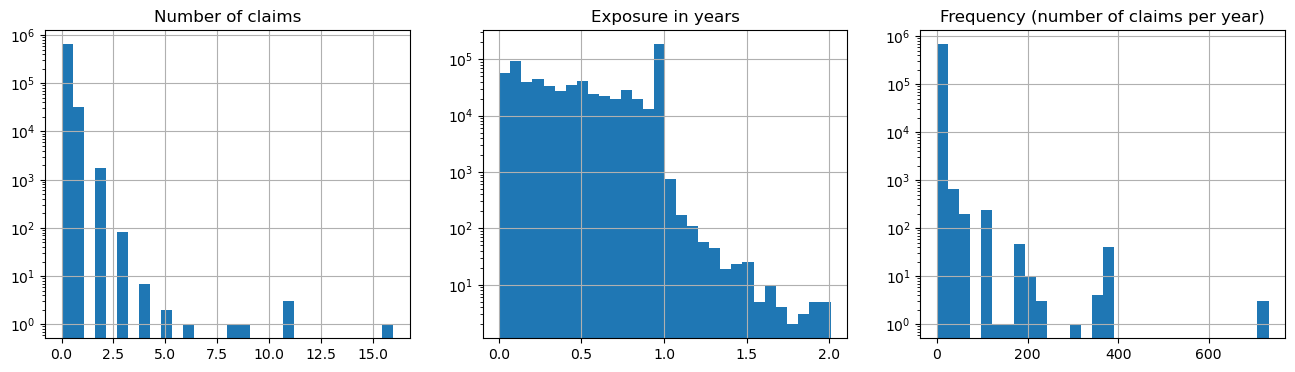

Hard to explain and predict the number of claims according to the frequency


In [37]:
df["Frequency"] = df["ClaimNb"] / df["Exposure"]

print("Average Frequency = {}".format(np.average(df["Frequency"], weights=df["Exposure"])))

print("Fraction of exposure with zero claims = {0:.1%}".format(df.loc[df["ClaimNb"] == 0, "Exposure"].sum() / df["Exposure"].sum()))

fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(16, 4))
ax0.set_title("Number of claims")
_ = df["ClaimNb"].hist(bins=30, log=True, ax=ax0)
ax1.set_title("Exposure in years")
_ = df["Exposure"].hist(bins=30, log=True, ax=ax1)
ax2.set_title("Frequency (number of claims per year)")
_ = df["Frequency"].hist(bins=30, log=True, ax=ax2)
plt.show()
print("Hard to explain and predict the number of claims according to the frequency")

***NB: Depends on which LM the data suit, the key is to have a proper transformation***

In [45]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer
from sklearn.compose import ColumnTransformer


log_scale_transformer = make_pipeline(FunctionTransformer(np.log, validate=False), StandardScaler())

linear_model_preprocessor = ColumnTransformer(
    [   ("passthrough_numeric", "passthrough", ["BonusMalus"]),
        ("binned_numeric", KBinsDiscretizer(n_bins=10, subsample=int(2e5), random_state=0),
                           ["VehAge", "DrivAge"],),
        ("log_scaled_numeric", log_scale_transformer, ["Density"]),
        ("onehot_categorical", OneHotEncoder(),
                              ["VehBrand", "VehPower", "VehGas", "Region", "Area"],  ),  ],
    
    remainder="drop",
)

In [48]:
from sklearn.dummy import DummyRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.33, random_state=0)

dummy = Pipeline(
    [
        ("preprocessor", linear_model_preprocessor),
        ("regressor", DummyRegressor(strategy="mean")),
    ]
).fit(df_train, df_train["Frequency"], regressor__sample_weight=df_train["Exposure"])

In [40]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_poisson_deviance


def score_estimator(estimator, df_test):
    """Score an estimator on the test set."""
    y_pred = estimator.predict(df_test)

    print(
        "MSE: %.3f"
        % mean_squared_error(
            df_test["Frequency"], y_pred, sample_weight=df_test["Exposure"]
        )
    )
    print(
        "MAE: %.3f"
        % mean_absolute_error(
            df_test["Frequency"], y_pred, sample_weight=df_test["Exposure"]
        )
    )

    # Ignore non-positive predictions, as they are invalid for
    # the Poisson deviance.
    mask = y_pred > 0
    if (~mask).any():
        n_masked, n_samples = (~mask).sum(), mask.shape[0]
        print(
            "WARNING: Estimator yields invalid, non-positive predictions "
            f" for {n_masked} samples out of {n_samples}. These predictions "
            "are ignored when computing the Poisson deviance."
        )

    print(
        "mean Poisson deviance: %.3f"
        % mean_poisson_deviance(
            df_test["Frequency"][mask],
            y_pred[mask],
            sample_weight=df_test["Exposure"][mask],
        )
    )


print("Constant mean frequency evaluation:")
score_estimator(dummy, df_test)

Constant mean frequency evaluation:
MSE: 0.564
MAE: 0.189
mean Poisson deviance: 0.625


***Generalized Linear Models***

In [41]:
from sklearn.linear_model import Ridge


ridge_glm = Pipeline(
    [
        ("preprocessor", linear_model_preprocessor),
        ("regressor", Ridge(alpha=1e-6)),
    ]
).fit(df_train, df_train["Frequency"], regressor__sample_weight=df_train["Exposure"])

print("Ridge evaluation:")
score_estimator(ridge_glm, df_test)

Ridge evaluation:
MSE: 0.560
MAE: 0.186
mean Poisson deviance: 0.597


***Directly fit with Poisson regression***

In [42]:
from sklearn.linear_model import PoissonRegressor

n_samples = df_train.shape[0]

poisson_glm = Pipeline(
    [
        ("preprocessor", linear_model_preprocessor),
        ("regressor", PoissonRegressor(alpha=1e-12, solver="newton-cholesky")),
    ]
)
poisson_glm.fit(
    df_train, df_train["Frequency"], regressor__sample_weight=df_train["Exposure"]
)

print("PoissonRegressor evaluation:")
score_estimator(poisson_glm, df_test)

PoissonRegressor evaluation:
MSE: 0.560
MAE: 0.186
mean Poisson deviance: 0.594


## ***Part I: GAM***
>
> Example from https://pygam.readthedocs.io/en/latest/notebooks/tour_of_pygam.html
- GAM: Generalized additive models (combining different models --ANN, Deep Learning)
- GAM is more developed in R rather than Python
- Another extension of GAM is Mixed Effective Models


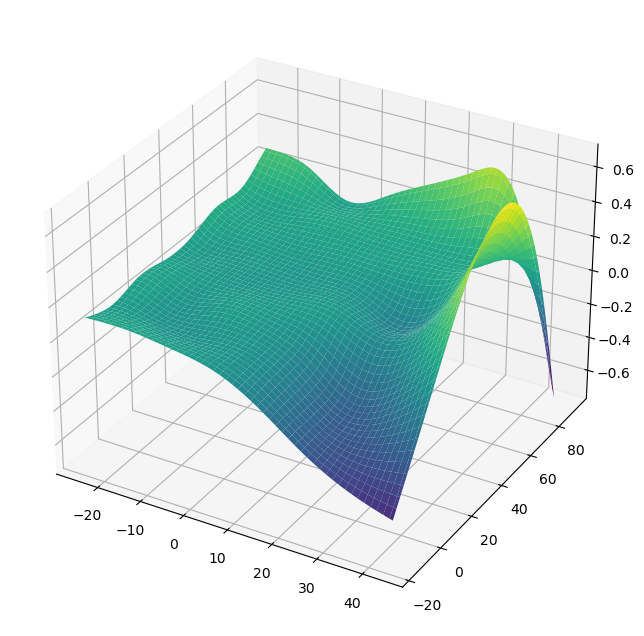

In [15]:
import numpy as np
import pandas as pd
from pygam import GAM, PoissonGAM, LinearGAM, s, f, te
from pygam.datasets import chicago
import matplotlib.pyplot as plt


X, y = chicago(return_X_y=True)

gam = PoissonGAM(s(0, n_splines=200) + te(3, 1) + s(2)).fit(X, y)

plt.ion()
plt.rcParams['figure.figsize'] = (12, 8)

XX = gam.generate_X_grid(term=1, meshgrid=True)
Z = gam.partial_dependence(term=1, X=XX, meshgrid=True)

ax = plt.axes(projection='3d')
ax.plot_surface(XX[0], XX[1], Z, cmap='viridis')
plt.show()

In [16]:
from pygam.datasets import toy_interaction

X, y = toy_interaction(return_X_y=True)

gam = LinearGAM(s(0, by=1)).fit(X, y)
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     20.8484
Link Function:                     IdentityLink Log Likelihood:                              -2296683.6446
Number of Samples:                        50000 AIC:                                           4593410.986
                                                AICc:                                          4593411.006
                                                GCV:                                                0.0101
                                                Scale:                                              0.0101
                                                Pseudo R-Squared:                                   0.9976
Feature Function                  Lam

C:\Users\wengang\AppData\Local\Temp\ipykernel_28416\671288597.py:6: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


<Figure size 1200x800 with 0 Axes>

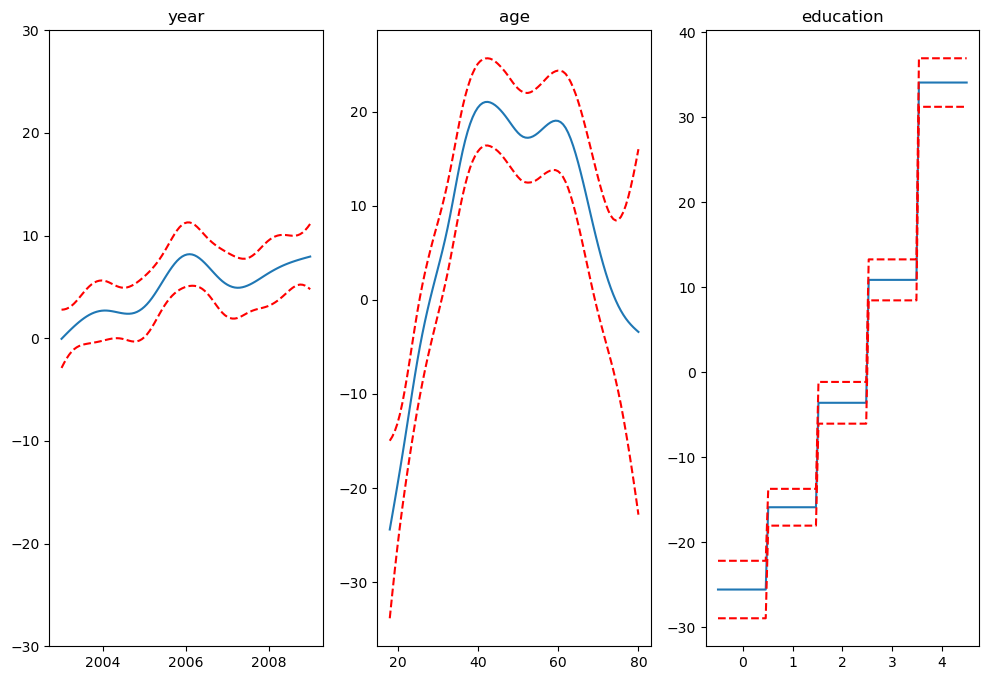

In [17]:
from pygam import LinearGAM, s, f
from pygam.datasets import wage

X, y = wage(return_X_y=True)

## model
gam = LinearGAM(s(0) + s(1) + f(2))
gam.gridsearch(X, y)


## plotting
plt.figure();
fig, axs = plt.subplots(1,3);

titles = ['year', 'age', 'education']
for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
    if i == 0:
        ax.set_ylim(-30,30)
    ax.set_title(titles[i]);

In [18]:
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     19.2602
Link Function:                     IdentityLink Log Likelihood:                                -24116.7451
Number of Samples:                         3000 AIC:                                            48274.0107
                                                AICc:                                           48274.2999
                                                GCV:                                             1250.3656
                                                Scale:                                           1235.9245
                                                Pseudo R-Squared:                                   0.2945
Feature Function                  Lam

C:\Users\wengang\AppData\Local\Temp\ipykernel_28416\3358381670.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()
